# **Adversarial Settings**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### In Adversarial Settings we generalize the process generating rewards. Instead of being sampled from a probability distribution, rewards are chosen by an adversary that can observe the bandit algorithm is facing.

## **The Adversarial Expert Setting**

### In Expert settings, at each round, an agent chooses an arm and incurs its loss, but can observe the losses of all the other arms.

### Thus, there is no exploration-exploitation trade-off dilemma, since exploration is pointless when all information is available.

In [2]:
class AdversarialExpertEnvironment:
    def __init__(self, loss_sequence):
        self.loss_sequence = loss_sequence
        self.t = 0

    def round(self): # we do not need to receive a specific arm
        l_t = self.loss_sequence[self.t, :] ## we return the whole loss vector
        self.t+=1 
        return l_t

In [3]:
# I see the algorithm, then decide an arbitrary sequence of rewards:
loss_seq = np.array([[0,1,0],[1,0,1],[1,1,1],[1,0,1],[0,1,0],[0,1,1],[0,0,0],[0,1,0],[1,1,0],[0,0,1]])
loss_seq.shape

(10, 3)

In [4]:
env = AdversarialExpertEnvironment(loss_seq)
env.t, env.round(), env.t

(0, array([0, 1, 0]), 1)

### Of course, the Adversarial setting generalizes the Stochastic setting, since the adversary is free to choose to sample the rewards from a probability distribution, thus any Stochastic MAB is also a special instance of Adversarial MAB.

### The notion of regret change its meaning, the clairvoyant is not the agent always choosing the best action at any moment, but the agent always pulling the arm having the best cumulative reward at the end.

In [5]:
print(f'Best achievable cumulative loss: {loss_seq.min(axis=1).sum()}')
print(f'Best achievable cumulative loss when always pulling the same arm: {loss_seq.sum(axis=0).min()}')

Best achievable cumulative loss: 1
Best achievable cumulative loss when always pulling the same arm: 4


### We will compare to the second.

### We need to define a new clairvoyant: _Best arm in hindsight_.

In [6]:
best_arm = np.argmin(loss_seq.sum(axis=0))
print(f'The best arm in hindsight is {best_arm}')

The best arm in hindsight is 0


In [7]:
clairvoyant_losses = loss_seq[:, best_arm]
clairvoyant_losses

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 0])

### Thus, the regret is defined as: $R_T = \mathbb{E}[\sum_{t=1}^T \ell_t(a)] - \min_a \sum_{t=1}^T \ell_t(a)$

## **Follow-The-Leader, and why it does not work**

### Play the arm with the smallest cumulative loss so far (the leader). 
### Intution: the best arm up to time $t-1$ may be the best one for the next time step too.

In [8]:
class FTLAgent:
    def __init__(self, K):
        self.K = K
        self.a_t = None
        self.cumulative_losses = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.a_t = np.argmin(self.cumulative_losses)
        return self.a_t
    
    def update(self, l_t):
        self.cumulative_losses += l_t
        self.t += 1

### It's a deterministic algorithm: the adversary can build a sequence of losses such that our agent incurs in linear regret.

### First build the sequence

In [9]:
T = 1000
K = 2
loss_seq = np.zeros((T, K))
dummy_agent = FTLAgent(K)
for t in range(T):
    a_t = dummy_agent.pull_arm()
    loss_seq[t, a_t] = 1 
    dummy_agent.update(loss_seq[t, :])

### Now try the algorithm

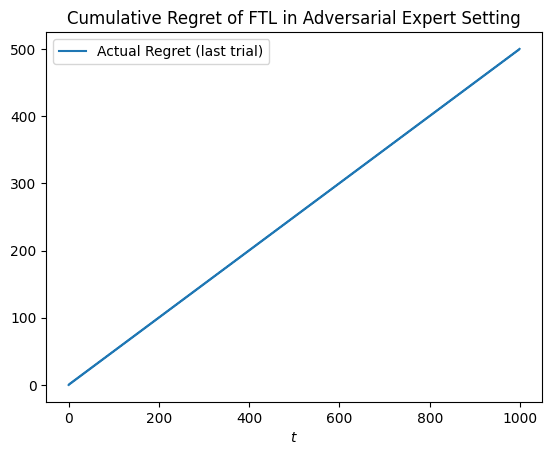

In [10]:
best_arm = np.argmin(loss_seq.sum(axis=0))
clairvoyant_losses = loss_seq[:, best_arm]

# we log to different cumulative losses for the agent
agent_losses = np.array([])
agent = FTLAgent(K)
env = AdversarialExpertEnvironment(loss_seq)
for t in range(T):
    a_t = agent.pull_arm()
    l_t = env.round()
    agent.update(l_t)
    # logging
    agent_losses = np.append(agent_losses, l_t[a_t])

plt.plot(np.cumsum(agent_losses-clairvoyant_losses), label='Actual Regret (last trial)')
plt.title('Cumulative Regret of FTL in Adversarial Expert Setting')
plt.xlabel('$t$')
plt.legend()
plt.show()

## **The Hedge algorithm**

### Let $a_t \sim x_t$, where $x_t = \frac{w_t(a)}{\sum_{a'} w_t(a')}$
### and $w_t(a) = \exp(-\eta \sum_{\tau=1}^{t-1} \ell_\tau(a))$

In [11]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

### Due to practical reasons, we generate the losses using a probability distribution. However, in principle, we would be free to choose any sequence we'd like.

In [12]:
T = 10000
K = 3
loss_seq = np.zeros((T, K))
np.random.seed(17)
loss_seq[:,0] = np.random.binomial(n=1, p=0.7, size=T)
loss_seq[:,1] = np.random.binomial(n=1, p=0.5, size=T)
loss_seq[:,2] = np.random.binomial(n=1, p=0.25, size=T)

### We distinguish two ways to compute the regret: 
- ### actual regret (considering the arm $a_t \sim x_t$ that is played)
- ### regret in expectation (over the distribution $x_t$).

### **Remark 1**: in adversarial settings, the expectation on regret is only taken w.r.t. to the randomness of the algorithm, since by definition the sequence of losses is not stochastic.

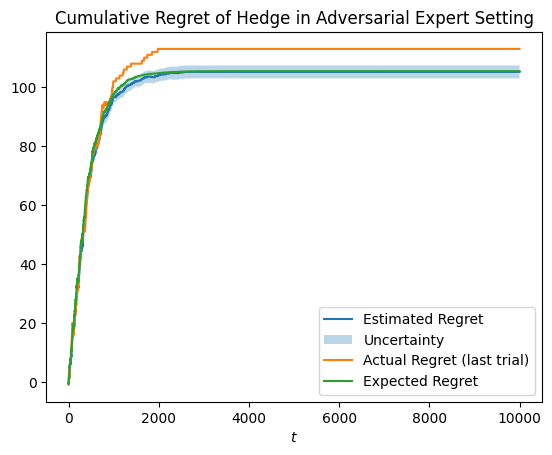

In [13]:
learning_rate = np.sqrt(np.log(K)/T) # we set the learning rate as prescribed by the theory

best_arm = np.argmin(loss_seq.sum(axis=0))
clairvoyant_losses = loss_seq[:, best_arm]

# we log to different cumulative losses for the agent
all_cumulative_regret = []
all_expected_regret = []
n_trials = 10
np.random.seed(35)
for seed in range(n_trials):
    agent_losses = []
    expected_agent_losses = []
    agent = HedgeAgent(K, learning_rate)
    env = AdversarialExpertEnvironment(loss_seq)
    for t in range(T):
        a_t = agent.pull_arm()
        l_t = env.round()
        agent.update(l_t)
        # logging
        agent_losses.append(l_t[a_t])
        expected_agent_losses.append(np.dot(l_t, agent.x_t))

    agent_losses = np.array(agent_losses)
    expected_agent_losses = np.array(expected_agent_losses)
    all_cumulative_regret.append(np.cumsum(-clairvoyant_losses+agent_losses))
    all_expected_regret.append(np.cumsum(-clairvoyant_losses+expected_agent_losses))

all_cumulative_regret = np.array(all_cumulative_regret)
plt.plot(all_cumulative_regret.mean(axis=0), label='Estimated Regret')
plt.fill_between(np.arange(T),
                 all_cumulative_regret.mean(axis=0)-all_cumulative_regret.std(axis=0)/np.sqrt(n_trials),
                 all_cumulative_regret.mean(axis=0)+all_cumulative_regret.std(axis=0)/np.sqrt(n_trials),
                 alpha=0.3,
                 label='Uncertainty')
plt.plot(np.cumsum(agent_losses-clairvoyant_losses), label='Actual Regret (last trial)') # on the last run only
plt.plot(np.cumsum(expected_agent_losses-clairvoyant_losses), label='Expected Regret')
plt.title('Cumulative Regret of Hedge in Adversarial Expert Setting')
plt.xlabel('$t$')
plt.legend()
plt.show()

### **Remark 2**: Hedge computes $x_t$ based only on the sequence of losses and not on the actual arms $x_\tau$ played before. Thus, we can compute the exact expected regret over the expectation induced by the algorithm. This will not be true for adversarial bandits.

### As $x_t$ is chosen deterministically, we can compute the expected regret in a single tiral.

In [14]:
# observe that the expected regret is indeed exact, and thus the same for each trial
for exp_regret in all_expected_regret:
    if not np.array_equal(exp_regret, all_expected_regret[-1]):
        print(exp_regret[-1],all_expected_regret[-1][-1])

In [15]:
print(f'Best arm in hindsight: {best_arm}')
print(f'Final allocation :{agent.x_t}') # the best arm is the one having more weight

Best arm in hindsight: 2
Final allocation :[2.20201475e-21 5.41612728e-12 1.00000000e+00]


In [16]:
print(f'Theoretical bound: {2*np.sqrt(T*np.log(K))}')
print(f'Actual Total Regret (last trial): {sum(agent_losses)-sum(clairvoyant_losses)}') 
print(f'Expected Total Regret: {sum(expected_agent_losses)-sum(clairvoyant_losses)}') 


Theoretical bound: 209.629414793641
Actual Total Regret (last trial): 113.0
Expected Total Regret: 105.46378244425341


 ### Observe that, differently from stochastic settings, the instantaneous **expected** regret can be **negative**.

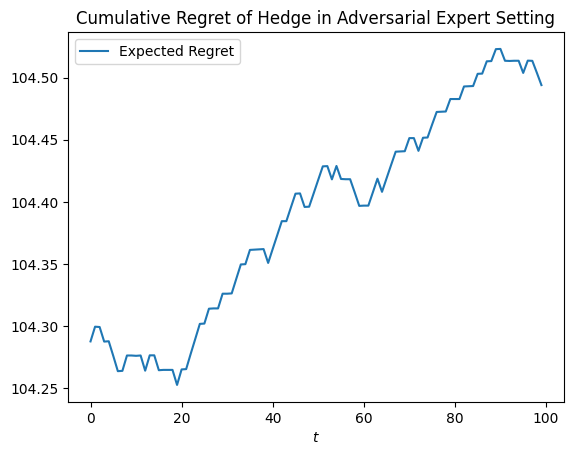

In [17]:
plt.plot(np.cumsum(expected_agent_losses-clairvoyant_losses)[1700:1800], label='Expected Regret')
plt.title('Cumulative Regret of Hedge in Adversarial Expert Setting')
plt.xlabel('$t$')
plt.legend()
plt.show()

In [18]:
t = 1759
w_t = np.exp(-learning_rate*np.sum(loss_seq[0:t-1],axis=0))
x_t = w_t/np.sum(w_t)
x_star = np.array([1 if i==best_arm else 0 for i in range(K)])
print(f't={t} l_t={loss_seq[t]} x_t={x_t} x*={x_star}')

t=1759 l_t=[0. 0. 1.] x_t=[2.01180727e-04 1.05744879e-02 9.89224331e-01] x*=[0 0 1]


## **The Adversarial Bandit Setting**

### In Bandit Settings, the agent chooses one arm and can only observe the loss associated to that single arm. Thus, the feedback received from the environment is limited. This problem is intrinsically harder than the expert setting, due to the more limited information available.

In [19]:
class AdversarialBanditEnvironment:
    def __init__(self, loss_sequence):
        self.loss_sequence = loss_sequence
        self.t = 0

    def round(self, a_t): # we need to receive a specific arm
        l_t = self.loss_sequence[self.t, a_t] ## we return only the loss corresponding to the chosen arm
        self.t+=1 
        return l_t

### As before, the sequence of losses is arbitrary.

In [20]:
# I see the algorithm, then decide the sequence of rewards:
loss_seq = np.array([[0,1,0],[1,0,1],[1,1,1],[1,0,1],[0,1,0],[0,1,1],[0,0,0],[0,1,0],[1,1,0],[0,0,1]])
env = AdversarialBanditEnvironment(loss_seq)
env.t, env.round(0), env.t

(0, np.int64(0), 1)

### As before, the regret is computed w.r.t. the best arm in hindsight

In [21]:
print(f'Best achievable cumulative loss: {loss_seq.min(axis=1).sum()}')
print(f'Best achievable cumulative loss when always pulling the same arm: {loss_seq.sum(axis=0).min()}')

Best achievable cumulative loss: 1
Best achievable cumulative loss when always pulling the same arm: 4


### We will compare to the second.

### However, the problem is now harder, since we can only observe the feedback associated to the arm we choose. Thus, we need to deal with the exploration-exploitation trade-off.

## **Extending Hedge to a Bandit Setting: the EXP3 Algorithm**

## We substitute the actual losses $\ell_t$ with an unbiased estimator $\tilde \ell_t$ s.t. $\mathbb{E}_t[\tilde \ell_t] = \ell_t$.
## Specifically, we use $\tilde \ell_t(a) = \frac{\ell_t(a)}{x_t(a)}\mathbb{I}[a_t=a]$

In [22]:
class EXP3Agent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        l_t_tilde = l_t/self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate*l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1

In [23]:
T = 10000
K = 3
loss_seq = np.zeros((T, K))
np.random.seed(17)
loss_seq[:,0] = np.random.binomial(n=1, p=0.7, size=T)
loss_seq[:,1] = np.random.binomial(n=1, p=0.5, size=T)
loss_seq[:,2] = np.random.binomial(n=1, p=0.25, size=T)

### Again, we can compute the received losses in two ways: actual and "expected". Note that in bandit settings, differently from expert, the expected loss cannot be computed in practice, since it would require to know all the losses associated to every arm.

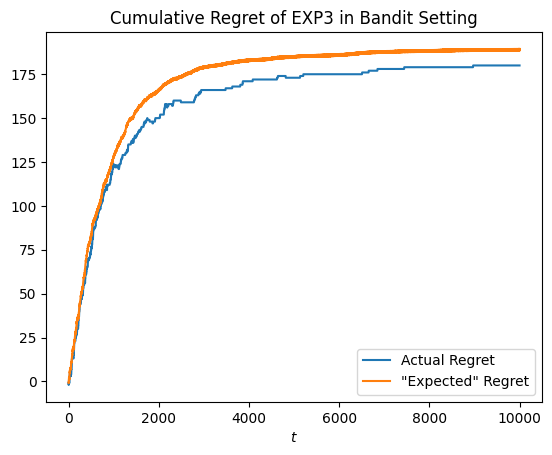

In [24]:
learning_rate = np.sqrt(np.log(K)/(K*T)) # we set the learning rate as prescribed by the theory (different from expert setting)

agent = EXP3Agent(K, learning_rate)
env = AdversarialBanditEnvironment(loss_seq)

best_arm = np.argmin(loss_seq.sum(axis=0))
clairvoyant_losses = loss_seq[:, best_arm]

agent_losses = np.array([])
expected_agent_losses = np.array([])
np.random.seed(30)
for t in range(T):
    a_t = agent.pull_arm()
    l_t = env.round(a_t)
    agent.update(l_t)
    # logging
    agent_losses = np.append(agent_losses, l_t)
    expected_agent_losses = np.append(expected_agent_losses,
                                    np.dot(agent.x_t,
                                           env.loss_sequence[t-1,:]))

plt.plot(np.cumsum(agent_losses-clairvoyant_losses), label='Actual Regret')
plt.plot(np.cumsum(expected_agent_losses-clairvoyant_losses), label='"Expected" Regret')
plt.title('Cumulative Regret of EXP3 in Bandit Setting')
plt.xlabel('$t$')
plt.legend()
plt.show()

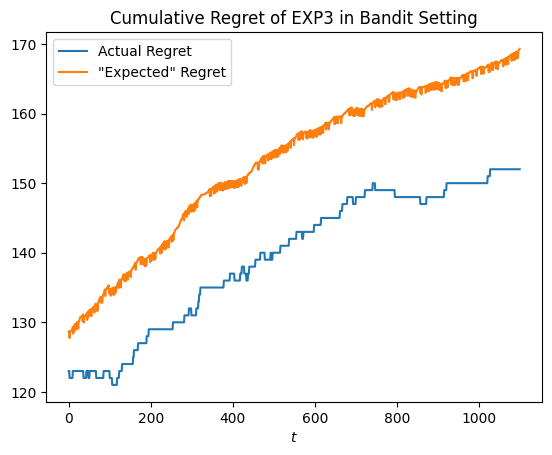

In [25]:
# the orange line is not thicker or wider, it's just going up and down
# (the best arm in hindsigh is not the best one at each time step)
plt.plot(np.cumsum(agent_losses-clairvoyant_losses)[1000:2100], label='Actual Regret')
plt.plot(np.cumsum(expected_agent_losses-clairvoyant_losses)[1000:2100], label='"Expected" Regret')
plt.title('Cumulative Regret of EXP3 in Bandit Setting')
plt.xlabel('$t$')
plt.legend()
plt.show()

## Is the orange line the actual Expected Regret?
## Let's see what happens over multiple trials

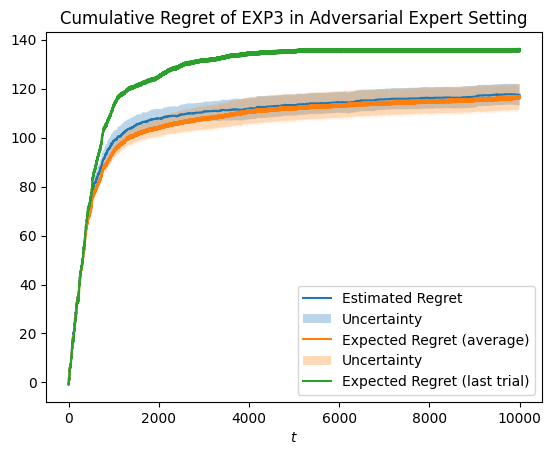

In [26]:
T = loss_seq.shape[0]
K = loss_seq.shape[1]
learning_rate = np.sqrt(np.log(K)/T) # we set the learning rate as prescribed by the theory

best_arm = np.argmin(loss_seq.sum(axis=0))
clairvoyant_losses = loss_seq[:, best_arm]

# we log to different cumulative losses for the agent
all_cumulative_regret = []
all_expected_regret = []
n_trials = 10
np.random.seed(30)
for seed in range(n_trials):
    agent_losses = []
    expected_agent_losses = []
    agent = EXP3Agent(K, learning_rate)
    env = AdversarialBanditEnvironment(loss_seq)
    for t in range(T):
        a_t = agent.pull_arm()
        l_t = env.round(a_t)
        agent.update(l_t)
        # logging
        agent_losses.append(l_t)
        expected_agent_losses.append(np.dot(agent.x_t,
                                            env.loss_sequence[t-1,:]))
    agent_losses = np.array(agent_losses)
    expected_agent_losses = np.array(expected_agent_losses)
    all_cumulative_regret.append(np.cumsum(-clairvoyant_losses+agent_losses))
    all_expected_regret.append(np.cumsum(-clairvoyant_losses+expected_agent_losses))

all_cumulative_regret = np.array(all_cumulative_regret)
all_expected_regret = np.array(all_expected_regret)
plt.plot(all_cumulative_regret.mean(axis=0), label='Estimated Regret')
plt.fill_between(np.arange(T),
                all_cumulative_regret.mean(axis=0)-all_cumulative_regret.std(axis=0)/np.sqrt(n_trials),
                all_cumulative_regret.mean(axis=0)+all_cumulative_regret.std(axis=0)/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.plot(np.array(all_expected_regret).mean(axis=0), label='Expected Regret (average)')
plt.fill_between(np.arange(T),
                all_expected_regret.mean(axis=0)-all_expected_regret.std(axis=0)/np.sqrt(n_trials),
                all_expected_regret.mean(axis=0)+all_expected_regret.std(axis=0)/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.plot(np.cumsum(expected_agent_losses-clairvoyant_losses), label='Expected Regret (last trial)') # obs: even with the same seed as before, the last trial gives a different "expected" regret
plt.title('Cumulative Regret of EXP3 in Adversarial Expert Setting')
plt.xlabel('$t$')
plt.legend()
plt.show()

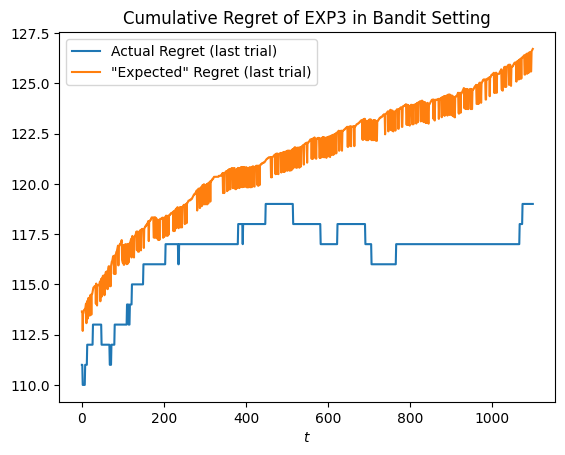

In [27]:
# the orange line is not thicker or wider, it's just going up and down
# (the best arm in hindsigh is not the best one at each time step)
plt.plot(np.cumsum(agent_losses-clairvoyant_losses)[1000:2100], label='Actual Regret (last trial)')
plt.plot(np.cumsum(expected_agent_losses-clairvoyant_losses)[1000:2100], label='"Expected" Regret (last trial)')
plt.title('Cumulative Regret of EXP3 in Bandit Setting')
plt.xlabel('$t$')
plt.legend()
plt.show()

### Remark: the agent only observes the loss associated to the chosen arm, expected loss cannot be computed without knowing the losses from all arms (as in the expert setting). Thus, the algorithm only reacts based on the actual loss incurred. The strategy $x_t$ played by the algorithm depends on the previously (randomly) selected arms:
- ### Expert setting, Hedge: $\sum_{t=1}^T \langle l_t,x_t \rangle$ is not stochastic
- ### Bandit setting, EXP3: $\sum_{t=1}^T \langle l_t,x_t \rangle$ is stochastic

In [28]:
print(f'Best arm in hindsight: {best_arm}')
print(f'Final allocation :{agent.x_t}') # the best arm is the one having more weight

Best arm in hindsight: 2
Final allocation :[1.65170391e-19 8.22099851e-04 9.99177900e-01]


In [29]:
print(f'Theoretical bound: {2*np.sqrt(T*K)}') # The theoretical bound has worsen dependence on K w.r.t. expert setting (from log(K) to sqrt(K))
print(f'Actual Total Regret {sum(agent_losses)-sum(clairvoyant_losses)}') 

Theoretical bound: 346.41016151377545
Actual Total Regret 132.0


### We can quantify the uncertainty on expected regret, where the only uncertainty source is algorithm's randomization.

In [30]:
def evaluate_agent_adversarial(agent_init, loss_seq, n_trials, seed=30):
    best_arm = np.argmin(loss_seq.sum(axis=0))
    clairvoyant_losses = loss_seq[:, best_arm]
    T = loss_seq.shape[0]
    K = loss_seq.shape[1]
    regret_per_trial = []
    # we keep the loss sequence fixed, we will only observe uncertainty due to algorithm's randomizations
    np.random.seed(seed)
    for trial in range(n_trials):
        agent = agent_init(K, T)
        env = AdversarialBanditEnvironment(loss_seq)
        
        # expected_agent_losses = []
        agent_losses = []
        for t in range(T):
            a_t = agent.pull_arm()
            l_t = env.round(a_t)
            agent.update(l_t)
            # logging
            # expected_agent_losses.append(np.dot(agent.x_t,
            #                                     env.loss_sequence[t-1,:]))
            # for coding purposes, the estiamtor above requires the agent to compute some x_t explicitly (see doubling trick)
            agent_losses.append(l_t)

        # both are unbiased estimators, but the second one is more natural
        # and works for any algorithm in a black box fashion 
        # cumulative_regret = np.cumsum(np.array(expected_agent_losses)-clairvoyant_losses)
        cumulative_regret = np.cumsum(np.array(agent_losses)-clairvoyant_losses)
        regret_per_trial.append(cumulative_regret)

    regret_per_trial = np.array(regret_per_trial)

    return regret_per_trial.mean(axis=0), regret_per_trial.std(axis=0)

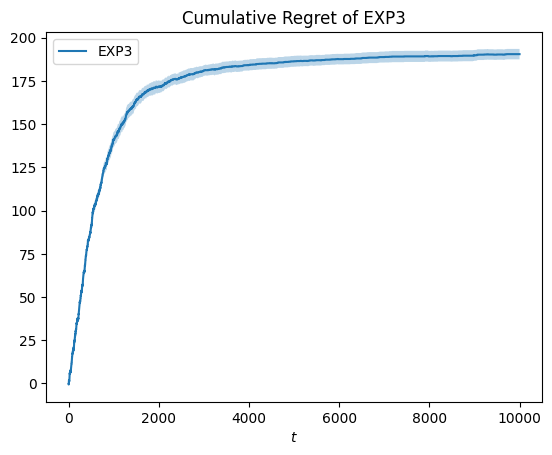

In [31]:
n_trials = 10
exp3_average_regret, exp3_regret_sd = evaluate_agent_adversarial(lambda K, T: EXP3Agent(K,np.sqrt(np.log(K)/(K*T))),
                                                                  loss_seq, n_trials)
plt.plot(np.arange(T), exp3_average_regret, label='EXP3')
plt.title('Cumulative Regret of EXP3')
plt.fill_between(np.arange(T),
                exp3_average_regret-exp3_regret_sd/np.sqrt(n_trials),
                exp3_average_regret+exp3_regret_sd/np.sqrt(n_trials),
                alpha=0.3)
plt.xlabel('$t$')
plt.legend()
plt.show()


## Anytime EXP3

### The basic version of EXP3 requires the tiem horizon as input to compute the learning rate. As usual, we can use the doubling trick if $T$ is unknown.

In [32]:
# same code from previous lab
class DoublingTrickAgent:
    def __init__(self, K, agent_init):
        self.K = K
        self.agent_init = agent_init
        self.a_t = None
        self.N_pulls = np.zeros(K)
        self.t = 0
        self.i = 0
        self.next_pahse_start = self.t + 2**(self.i)
        self.current_agent = self.agent_init(K,2**(self.i))
    
    def pull_arm(self):
        self.a_t = self.current_agent.pull_arm()
        return self.a_t
    
    def update(self, r_t):
        self.current_agent.update(r_t)
        self.N_pulls[self.a_t] += 1
        self.t += 1
        if self.t == self.next_pahse_start:
            self.i += 1
            T_i = 2**(self.i)
            self.next_pahse_start = self.t + T_i
            self.current_agent = self.agent_init(self.K, T_i)

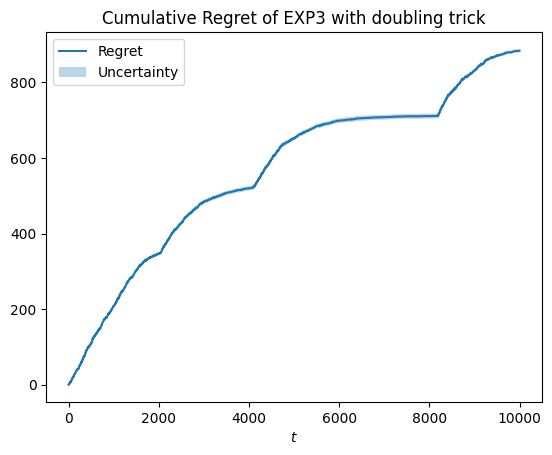

In [33]:
n_trials = 10
exp3_init = lambda K,T_i : EXP3Agent(K, np.sqrt(np.log(K)/(K*T)))
average_regret, regret_sd = evaluate_agent_adversarial(lambda K, T: DoublingTrickAgent(K, exp3_init),
                                                                  loss_seq, n_trials)
plt.plot(np.arange(T), average_regret, label='Regret')
plt.title('Cumulative Regret of EXP3 with doubling trick')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3, label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

### We can do better: time varying learning rate

### $x_t(a) = \frac{\exp(-\eta_t \sum_{\tau=1}^{t-1} \tilde \ell_\tau(a))}{\sum_{a'}\exp(-\eta_t \sum_{\tau=1}^{t-1} \tilde \ell_\tau(a'))} $

In [34]:
class EXP3AnytimeAgent:
    def __init__(self, K, learning_rate_f):
        self.K = K
        self.learning_rate_f = learning_rate_f
        self.est_cumulative_losses = np.zeros(K)
        self.a_t = None
        # for logging
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        learning_rate = self.learning_rate_f(self.t+1)
        l_t_tilde = l_t/self.x_t[self.a_t]
        self.est_cumulative_losses[self.a_t] += l_t_tilde
        self.weights = np.exp(-learning_rate*self.est_cumulative_losses)
        self.N_pulls[self.a_t] += 1
        self.t += 1

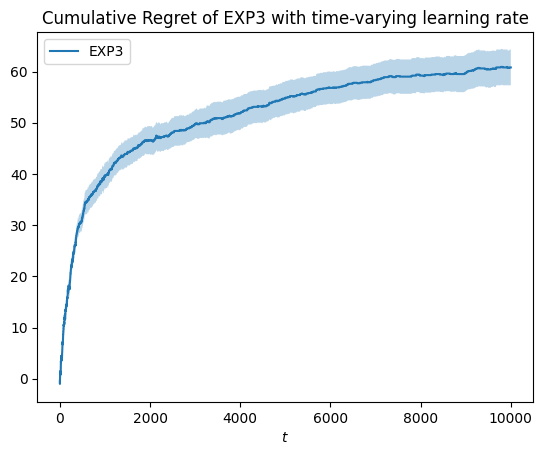

In [35]:
n_trials = 10
learning_rate_f = lambda t: np.sqrt(np.log(K)/(K*t))
exp3_average_regret, exp3_regret_sd = evaluate_agent_adversarial(lambda K, T: EXP3AnytimeAgent(K,learning_rate_f),
                                                                  loss_seq, n_trials)
plt.plot(np.arange(T), exp3_average_regret, label='EXP3')
plt.title('Cumulative Regret of EXP3 with time-varying learning rate')
plt.fill_between(np.arange(T),
                exp3_average_regret-exp3_regret_sd/np.sqrt(n_trials),
                exp3_average_regret+exp3_regret_sd/np.sqrt(n_trials),
                alpha=0.3)
plt.xlabel('$t$')
plt.legend()
plt.show()


## EXP3 in a stochastic setting.
### EXP3 has sublinear pesudo-regret in stochastic settings. However, it performs worse than dedicated algorithms.

In [36]:
class BernoulliStochasticEnvironment:
    def __init__(self, p, T):
        self.K = len(p)
        self.rewards = np.random.binomial(n=1, p=p, size=(T, self.K))
        self.t = 0

    def round(self, a_t):
        r_t = self.rewards[self.t, a_t]
        self.t +=1
        return r_t

class TSAgent:
    def __init__(self, K):
        self.K = K
        self.a_t = None
        self.alpha, self.beta = np.ones(K), np.ones(K)
        # logging
        self.N_pulls = np.zeros(K)
        self.theta = []

    def pull_arm(self):
        theta = np.random.beta(self.alpha, self.beta)
        self.theta.append(theta)
        self.a_t = np.argmax(theta)
        return self.a_t
    
    def update(self, r_t):
        self.alpha[self.a_t] += r_t
        self.beta[self.a_t] += 1-r_t
        self.N_pulls[self.a_t] += 1

In [37]:
def compare_agents_stochastic(p, T, agent1_init, agent2_init, n_trials, seed=42):
    best_action = np.argmax(p)
    K = len(p)
    expected_clairvoyant_rewards = np.repeat(p[best_action], T)

    first_regret_per_trial = []
    sec_regret_per_trial = []

    np.random.seed(seed)
    for _ in range(n_trials):
        state = np.random.get_state()
        env = BernoulliStochasticEnvironment(p, T)
        agent1 = agent1_init(K, T)

        agent_rewards = np.array([])
        for t in range(T):
            a_t = agent1.pull_arm()
            r_t = env.round(a_t)
            agent1.update(r_t)

            agent_rewards = np.append(agent_rewards, r_t)
        
        cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
        first_regret_per_trial.append(cumulative_regret)

        np.random.set_state(state)
        env = BernoulliStochasticEnvironment(p, T)
        agent2 = agent2_init(K, T)

        agent_rewards = np.array([])
        for t in range(T):
            a_t = agent2.pull_arm()
            r_t = env.round(a_t)
            agent2.update(r_t)

            agent_rewards = np.append(agent_rewards, r_t)

        cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
        sec_regret_per_trial.append(cumulative_regret)

    first_regret_per_trial = np.array(first_regret_per_trial)
    sec_regret_per_trial = np.array(sec_regret_per_trial)

    first_avg_regret = first_regret_per_trial.mean(axis=0)
    first_regret_sd = first_regret_per_trial.std(axis=0)
    sec_avg_regret = sec_regret_per_trial.mean(axis=0)
    sec_regret_sd = sec_regret_per_trial.std(axis=0)
    return (first_avg_regret, first_regret_sd), (sec_avg_regret, sec_regret_sd)

### As the stochastic setting is defined with rewards, we need to adapt our EXP3 implementation. Since we already have an implementation working with losses, we can simply convert the rewards into losses: $\ell_t(a) = 1 - r_t(a)$

In [38]:
class RewardsToLossesWrapper:
    def __init__(self, losses_agent):
        self.losses_agent = losses_agent
        # you may add anything you want to log

    def pull_arm(self):
        return self.losses_agent.pull_arm()

    def update(self, r_t):
        l_t = 1 - r_t
        self.losses_agent.update(l_t)

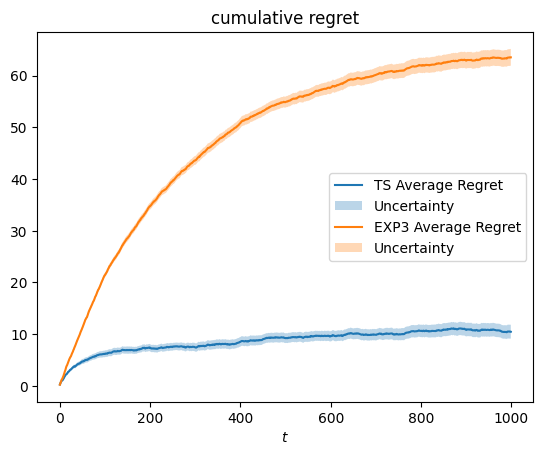

In [39]:
p = np.array([0.25, 0.5, 0.75])
K = len(p)
T = 1000

n_trials = 100

ucb_results, etc_results = compare_agents_stochastic(p,T,
                                          lambda K,T : TSAgent(K), 
                                          lambda K,T : RewardsToLossesWrapper(
                                              EXP3Agent(K, np.sqrt(np.log(K)/(K*T)))
                                              ),
                                          n_trials)
ucb_average_regret, ucb_regret_sd = ucb_results
etc_average_regret, etc_regret_sd = etc_results


plt.plot(np.arange(T), ucb_average_regret, label='TS Average Regret')
plt.fill_between(np.arange(T),
                ucb_average_regret-ucb_regret_sd/np.sqrt(n_trials),
                ucb_average_regret+ucb_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.plot(np.arange(T), etc_average_regret, label='EXP3 Average Regret')
plt.fill_between(np.arange(T),
                etc_average_regret-etc_regret_sd/np.sqrt(n_trials),
                etc_average_regret+etc_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.title('cumulative regret')
plt.xlabel('$t$')
plt.legend()
plt.show()

### Alternatively, we can use a slightly different EXP3 that is naturally developed by considering rewards instead of losses:
- ### $w_t(a) = \exp(\eta\sum_{\tau=1}^{t-1}\tilde r_t(a))$
- ### $\tilde r_t(a) = \frac{r_t(a)}{x_t(a)}\mathbb{I}[a_t=a]$
### The theoretical analysis is basically the same, and the algorithm provides the same theoretical guarantees.

In [40]:
# you may also use EXP3 with a wrapper to convert from losses to reward
class EXP3AgentRewards:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, r_t):
        r_t_tilde = r_t/self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(self.learning_rate*r_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1

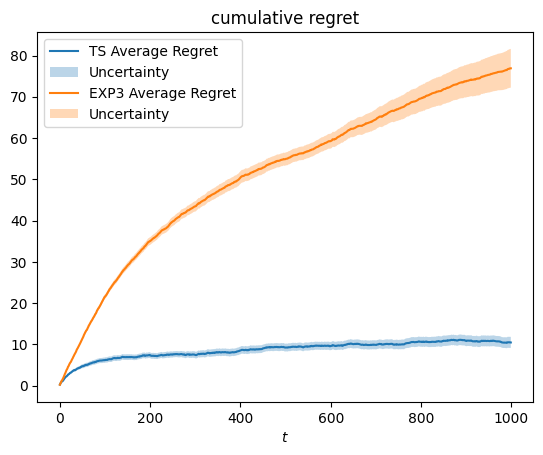

In [41]:
p = np.array([0.25, 0.5, 0.75])
K = len(p)
T = 1000

n_trials = 100

ucb_results, etc_results = compare_agents_stochastic(p,T,
                                          lambda K,T : TSAgent(K), 
                                          lambda K,T : EXP3AgentRewards(K, np.sqrt(np.log(K)/(K*T))),
                                          n_trials)
ucb_average_regret, ucb_regret_sd = ucb_results
etc_average_regret, etc_regret_sd = etc_results


plt.plot(np.arange(T), ucb_average_regret, label='TS Average Regret')
plt.fill_between(np.arange(T),
                ucb_average_regret-ucb_regret_sd/np.sqrt(n_trials),
                ucb_average_regret+ucb_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.plot(np.arange(T), etc_average_regret, label='EXP3 Average Regret')
plt.fill_between(np.arange(T),
                etc_average_regret-etc_regret_sd/np.sqrt(n_trials),
                etc_average_regret+etc_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.title('cumulative regret')
plt.xlabel('$t$')
plt.legend()
plt.show()

### A similar variant can be devised with time-varying learning rate

In [42]:
class EXP3AnytimeAgentRewards:
    def __init__(self, K, learning_rate_f):
        self.K = K
        self.learning_rate_f = learning_rate_f
        self.est_cumulative_rewards = np.zeros(K)
        self.a_t = None
        # for logging
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, r_t):
        learning_rate = self.learning_rate_f(self.t+1)
        r_t_tilde = r_t/self.x_t[self.a_t]
        self.est_cumulative_rewards[self.a_t] += r_t_tilde
        self.weights = np.exp(learning_rate*self.est_cumulative_rewards)
        self.N_pulls[self.a_t] += 1
        self.t += 1

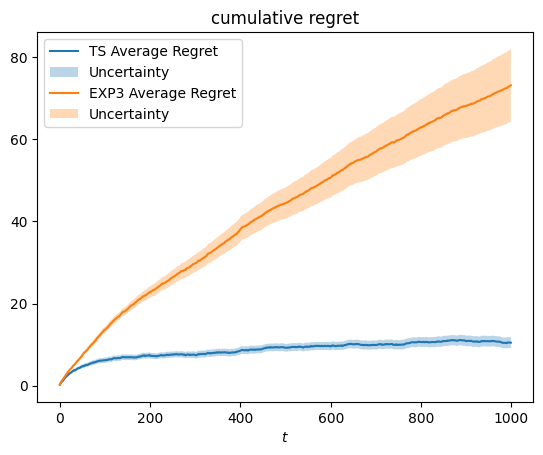

In [43]:
p = np.array([0.25, 0.5, 0.75])
K = len(p)
T = 1000

n_trials = 100
learning_rate_f = lambda t: np.sqrt(np.log(K)/(K*t))

ucb_results, etc_results = compare_agents_stochastic(p,T,
                                          lambda K,T : TSAgent(K), 
                                          lambda K,T : EXP3AnytimeAgentRewards(K, learning_rate_f),
                                          n_trials)
ucb_average_regret, ucb_regret_sd = ucb_results
etc_average_regret, etc_regret_sd = etc_results


plt.plot(np.arange(T), ucb_average_regret, label='TS Average Regret')
plt.fill_between(np.arange(T),
                ucb_average_regret-ucb_regret_sd/np.sqrt(n_trials),
                ucb_average_regret+ucb_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.plot(np.arange(T), etc_average_regret, label='EXP3 Average Regret')
plt.fill_between(np.arange(T),
                etc_average_regret-etc_regret_sd/np.sqrt(n_trials),
                etc_average_regret+etc_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.title('cumulative regret')
plt.xlabel('$t$')
plt.legend()
plt.show()

### Remark: the algorithm obtained by converting the rewards into losses and the one with different weights and estimators are not exactly the same. They become perfectly equivalent if you use the estimator $\tilde r_t(a) = 1 -\frac{1 - r_t(a)}{x_t(a)}\mathbb{I}[a_t=a]$. Both this and $\tilde r_t(a) = \frac{r_t(a)}{x_t(a)}\mathbb{I}[a_t=a]$ are unbiased and provide the same theoretical guarantees.